In [443]:
import dgl
import torch
import numpy as np
from indigo import *


**Molecule into DGLGraph**

In [442]:
indigo = Indigo()
indigo.setOption("ignore-stereochemistry-errors", True)
indigo.setOption("ignore-bad-valence", True)

Featurizers

In [465]:
import torch.nn.functional as F

def featurize_atoms(mol):
    feats = []
    for atom in mol.iterateAtoms():
        feats.append(atom.atomicNumber())
    return {"atomic": F.one_hot(torch.tensor(feats), 67)}

def featurize_edges(mol):
    feats = []
    for bond in mol.iterateBonds():
        feats.append(float(bond.bondOrder()))
    return {'ord': torch.tensor(feats*2).reshape(-1, 1).float()}
    


Featurize


In [466]:
def featurize(mol, g, node_featurizer=None, edge_featurizer=None):
    if node_featurizer is not None:
        g.ndata.update(node_featurizer(mol))

    if edge_featurizer is not None:
        g.edata.update(edge_featurizer(mol))

    return g

In [467]:
def smiles_to_graph(smiles):

    mol = indigo.loadMolecule(smiles)
    num_atoms = mol.countAtoms()
    g = dgl.graph(([], []), idtype=torch.int32)
    # Add nodes
    g.add_nodes(num_atoms)
    # Add edges
    src_list = []
    dst_list = []
    for bond in mol.iterateBonds():
        u = bond.source().index()
        v = bond.destination().index()
        src_list.extend([u, v])
        dst_list.extend([v, u])
    
    g.add_edges(torch.IntTensor(src_list), torch.IntTensor(dst_list))

    return featurize(mol, g, node_featurizer=featurize_atoms, edge_featurizer=featurize_edges)

**Create graph**

In [82]:
g = smiles_to_graph('CC\C(=C(\CC)/c1ccc(O)cc1)\c2ccc(O)cc2')
G = dgl.to_networkx(g)
# from dgl.geometry import neighbor_matching
# res = neighbor_matching(g)
# res

Graph(num_nodes=20, num_edges=42,
      ndata_schemes={'atomic': Scheme(shape=(1,), dtype=torch.float32)}
      edata_schemes={'ord': Scheme(shape=(1,), dtype=torch.float32)})

**Visualization**

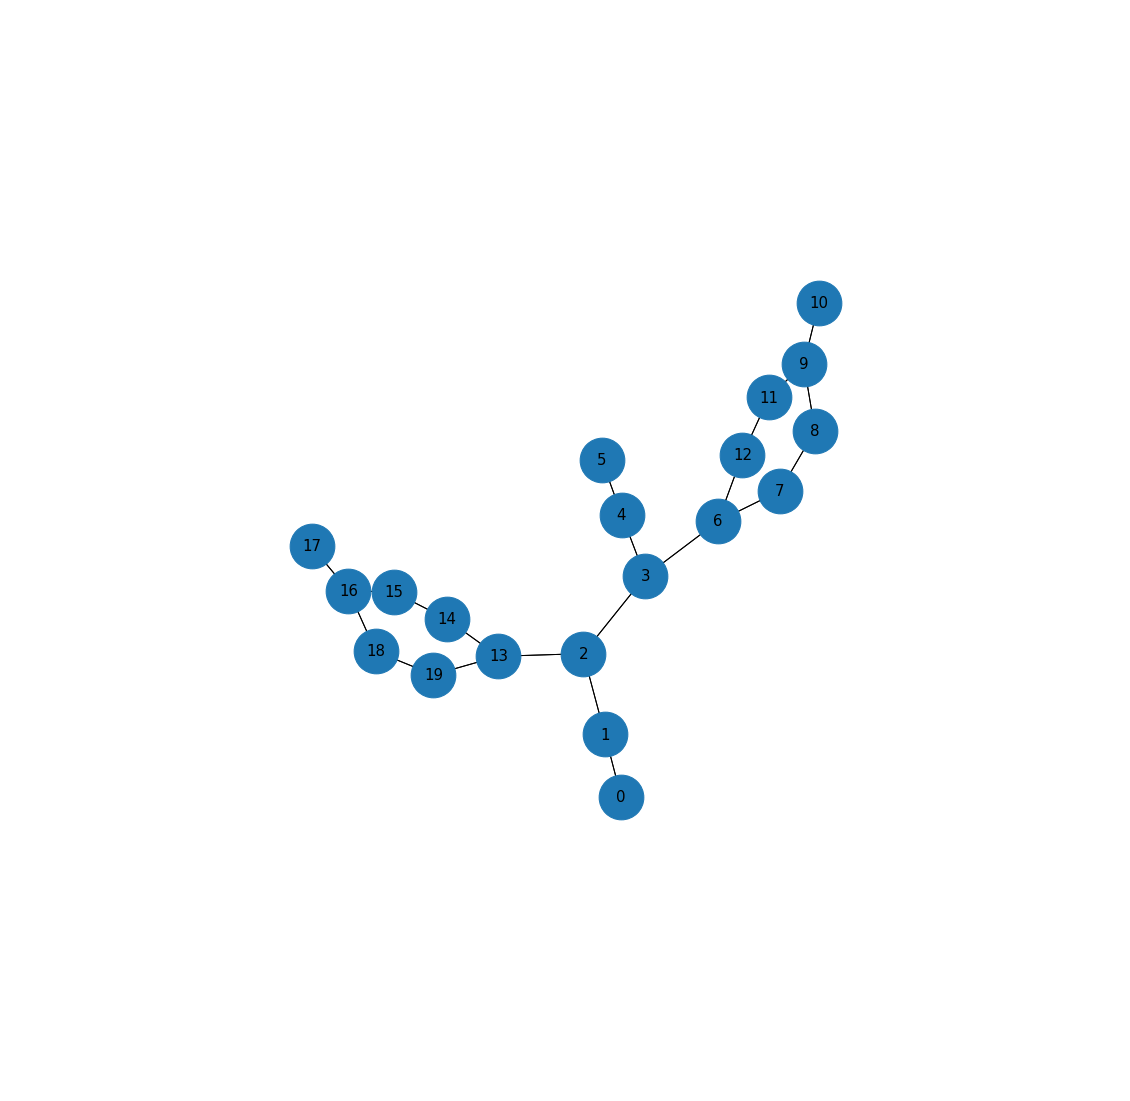

In [23]:
import matplotlib.pyplot as plt
import networkx as nx
plt.rcParams["figure.figsize"] = (20,20)


pos = nx.spring_layout(G, seed=30)
plt.figure(1)
nx.draw_networkx_nodes(G, pos, node_size=2000)
nx.draw_networkx_edges(G, pos) 
nx.draw_networkx_labels(G, pos, font_size=15, font_family="sans-serif")
ax = plt.gca()
ax.margins(0.5)
plt.axis("off")
plt.show()


In [3]:
import torch.nn as nn
import torch.nn.functional as F
from dgl.data import DGLDataset
from dgl.data.utils import split_dataset
from dgl.dataloading import GraphDataLoader
from dgl.nn.pytorch import Set2Set, NNConv
from tqdm.auto import tqdm
from sklearn.metrics import r2_score
import pandas as pd


**GCN for property prediction**

In [2]:
file_name = "Adrenergic_dataset.csv"
target =  "logP" # "AdrA1A_PCHEMBL_VALUE"
smiles = "Structure"

df = pd.read_csv(file_name)
df = df.loc[df[target].notnull()]
data = dict(zip(df[smiles], df[target]))


(Graph(num_nodes=20, num_edges=42,
      ndata_schemes={'atomic': Scheme(shape=(60,), dtype=torch.int64)}
      edata_schemes={'ord': Scheme(shape=(1,), dtype=torch.float32)}), tensor(4.8710))


*Dataset*

In [470]:
class MolDataset(DGLDataset):
    def __init__(self, data):
        super().__init__(name='mols')
        
    def process(self):
        self.graphs = []
        self.labels = []
        for smiles, label in data.items():
            self.graphs.append(smiles_to_graph(smiles))
            self.labels.append(label)

        self.gclasses = len(self.labels)
        self.dim_nfeats = len(self.graphs[0].ndata['atomic'][0])
        self.dim_efeats = len(self.graphs[0].edata['ord'][0])
        self.labels = torch.FloatTensor(self.labels)
        
        
        
    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]
    
    def __len__(self):
        return len(self.graphs)


*Dataloaders*

In [472]:
def load_data(dataset):
    train_set, val_set, test_set = split_dataset(dataset, frac_list=None, shuffle=False, random_state=None)
    train_loader = GraphDataLoader(dataset=train_set, shuffle=True, drop_last=False)
    val_loader = GraphDataLoader(dataset=val_set, shuffle=True, drop_last=False)
    test_loader = GraphDataLoader(dataset=test_set, shuffle=True, drop_last=False)
    return train_loader, val_loader, test_loader


*Model*

In [ ]:
class MPNNGNN(nn.Module):

    def __init__(self, node_in_feats, edge_in_feats, node_out_feats=64,
                 edge_hidden_feats=128, num_step_message_passing=6):
        super(MPNNGNN, self).__init__()

        self.project_node_feats = nn.Sequential(
            nn.Linear(node_in_feats, node_out_feats),
            nn.ReLU()
        )
        self.num_step_message_passing = num_step_message_passing
        edge_network = nn.Sequential(
            nn.Linear(edge_in_feats, edge_hidden_feats),
            nn.ReLU(),
            nn.Linear(edge_hidden_feats, node_out_feats * node_out_feats)
        )
        self.gnn_layer = NNConv(
            in_feats=node_out_feats,
            out_feats=node_out_feats,
            edge_func=edge_network,
            aggregator_type='sum'
        )
        self.gru = nn.GRU(node_out_feats, node_out_feats)

    def forward(self, g, node_feats, edge_feats):
        node_feats = self.project_node_feats(node_feats) 
        hidden_feats = node_feats.unsqueeze(0)           

        for _ in range(self.num_step_message_passing):
            node_feats = F.relu(self.gnn_layer(g, node_feats, edge_feats))
            node_feats, hidden_feats = self.gru(node_feats.unsqueeze(0), hidden_feats)
            node_feats = node_feats.squeeze(0)

        return node_feats

In [ ]:
class MLPRegressor(nn.Module):

    def __init__(self, in_feats, hidden_feats, n_tasks, dropout=0.):
        super(MLPRegressor, self).__init__()

        self.predict = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_feats, hidden_feats),
            nn.ReLU(),
            nn.Linear(hidden_feats, n_tasks)
        )

    def forward(self, h):
        return self.predict(h)

In [ ]:
class MPNNRegressor(nn.Module):

    def __init__(self, in_node_feats, in_edge_feats, node_hidden_dim, edge_hidden_dim,
                 num_step_message_passing, num_step_set2set, num_layer_set2set, n_tasks,
                 regressor_hidden_feats=128, dropout=0.):
        super(MPNNRegressor, self).__init__()
        self.gnn = MPNNGNN(in_node_feats, in_edge_feats, node_hidden_dim,
                           edge_hidden_dim, num_step_message_passing)
        self.readout = Set2Set(node_hidden_dim, num_step_set2set, num_layer_set2set)
        readout_feats = 2 * node_hidden_dim
        self.regressor = MLPRegressor(readout_feats, regressor_hidden_feats, n_tasks, dropout)


    def forward(self, bg, node_feats, edge_feats):

        feats = self.gnn(bg, node_feats, edge_feats)
        h_g = self.readout(bg, feats)

        return self.regressor(h_g)

*Parametrs*

In [ ]:
{
  "lr": 3e-4,
  "weight_decay": 0,
  "patience": 30,
  "batch_size": 128,
  "node_out_feats": 64,
  "edge_hidden_feats": 128,
  "num_step_message_passing": 6,
  "num_step_set2set": 6,
  "num_layer_set2set": 3
}


In [500]:
MPNN_params = {
    'node_hidden_dim': 64,
    'edge_hidden_dim': 16,
    'num_step_message_passing': 2,
    'num_step_set2set': 3,
    'num_layer_set2set': 2,
    'regressor_hidden_feats': 32,
    'dropout': 0.,
    'n_tasks': 1
}

dataset = MolDataset(data)
train_loader, val_loader, test_loader = load_data(dataset)
num_epoch = 20
model = MPNNRegressor(dataset.dim_nfeats, dataset.dim_efeats, **MPNN_params)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fcn = torch.nn.SmoothL1Loss()

*Training*

In [501]:
for epoch in tqdm(range(num_epoch)):
    losses = list()
    for batched_graph, labels in train_loader:

        node_feats = batched_graph.ndata['atomic'].float()
        edge_feats = batched_graph.edata['ord'].float()
        prediction = model(batched_graph, node_feats, edge_feats)
        loss = loss_fcn(prediction, labels)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch: {}/{}.............'.format(epoch, num_epoch), end=' ')
    print("Loss: {:.4f}".format(loss.mean()))
   

  0%|          | 0/20 [00:00<?, ?it/s]C:\Users\Diana_Peres\Miniconda3\envs\indigo\lib\site-packages\torch\nn\modules\loss.py:912: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)
C:\Users\Diana_Peres\Miniconda3\envs\indigo\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
  5%|▌         | 1/20 [00:42<13:19, 42.09s/it]

Epoch: 0/20............. Loss: 0.7122


 10%|█         | 2/20 [01:26<13:00, 43.38s/it]

Epoch: 1/20............. Loss: 0.0912


 15%|█▌        | 3/20 [02:11<12:28, 44.01s/it]

Epoch: 2/20............. Loss: 0.0223


 20%|██        | 4/20 [02:55<11:46, 44.17s/it]

Epoch: 3/20............. Loss: 0.7424


 25%|██▌       | 5/20 [03:40<11:04, 44.33s/it]

Epoch: 4/20............. Loss: 1.0003


 30%|███       | 6/20 [04:27<10:36, 45.43s/it]

Epoch: 5/20............. Loss: 0.1003


 35%|███▌      | 7/20 [05:14<09:56, 45.87s/it]

Epoch: 6/20............. Loss: 0.0304


 40%|████      | 8/20 [06:03<09:20, 46.73s/it]

Epoch: 7/20............. Loss: 0.3217


 45%|████▌     | 9/20 [06:50<08:35, 46.90s/it]

Epoch: 8/20............. Loss: 0.0724


 50%|█████     | 10/20 [07:46<08:16, 49.69s/it]

Epoch: 9/20............. Loss: 0.0768


 55%|█████▌    | 11/20 [08:43<07:47, 51.93s/it]

Epoch: 10/20............. Loss: 0.1326


 60%|██████    | 12/20 [09:33<06:50, 51.35s/it]

Epoch: 11/20............. Loss: 0.3476


 65%|██████▌   | 13/20 [10:20<05:50, 50.01s/it]

Epoch: 12/20............. Loss: 0.3130


 70%|███████   | 14/20 [11:08<04:56, 49.35s/it]

Epoch: 13/20............. Loss: 1.0708


 75%|███████▌  | 15/20 [11:58<04:08, 49.61s/it]

Epoch: 14/20............. Loss: 0.0530


 80%|████████  | 16/20 [12:43<03:13, 48.39s/it]

Epoch: 15/20............. Loss: 0.0242


 85%|████████▌ | 17/20 [13:29<02:22, 47.44s/it]

Epoch: 16/20............. Loss: 0.1225


 90%|█████████ | 18/20 [14:15<01:34, 47.26s/it]

Epoch: 17/20............. Loss: 0.0576


 95%|█████████▌| 19/20 [15:02<00:47, 47.03s/it]

Epoch: 18/20............. Loss: 0.0333


100%|██████████| 20/20 [15:46<00:00, 47.31s/it]

Epoch: 19/20............. Loss: 0.1361


In [502]:
from sklearn.metrics import mean_absolute_error

def evaluate(model, loader):
   
    preds = []
    labels = []
    model.eval()
    
    with torch.no_grad():
        for batched_graph, label in loader:
           
            node_feats = batched_graph.ndata['atomic'].float()
            edge_feats = batched_graph.edata['ord'].float()
            prediction = model(batched_graph, node_feats, edge_feats)
            preds.append(float(prediction))
            labels.append(float(label))

        print(f'R2 score: {r2_score(labels, preds):.2f}')
        print(f'MAE: {mean_absolute_error(labels, preds):.2f}')

    model.train()

In [503]:
evaluate(model, val_loader)

R2 score: 0.66
MAE: 0.41
